nfeatures 784
Before metric train
Entering metric train


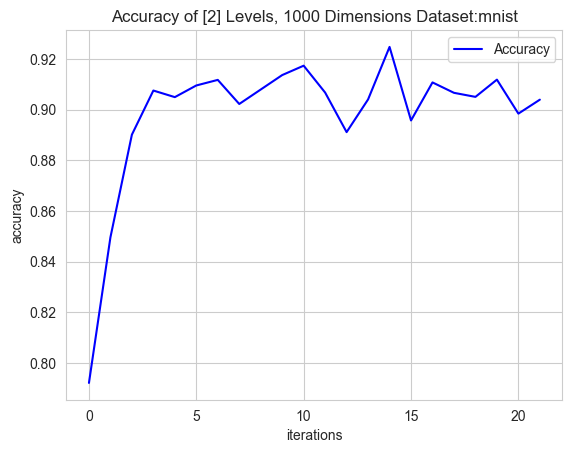

Maximum Accuracy:0.9247000217437744
{('mnist', 2): 0.9247000217437744}


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import HD
import test_HD
import dataset_utils
import torch.nn.functional as F

In [2]:
teacher_model = torch.load("./model/model.pth")

In [3]:
dataset = ["mnist"]
levels = [2]
metric_lrs = [0.0001]
HD_lrs =[1]
accs = {}
nFeatures, nClasses, x_train, y_train, x_test, y_test, train_loader, test_loader\
        = dataset_utils.load_dataset("mnist", 256, "cpu")
student_model = HD.HDC(dim = nFeatures, D=500, num_classes=nClasses, enc_type= 'RP', device="cpu")

In [20]:
class DistillationLoss:
    def __init__(self, T, alpha):
        super(DistillationLoss, self).__init__()
        self.T = T
        self.alpha = alpha

    def __call__(self, output, target, teacher_output):
        # Compute the cross-entropy loss between the student's output and the target
        ce_loss = nn.functional.cross_entropy(output, target)

        # Compute the KL divergence between the teacher's output and the student's "soft" output
        soft_output = nn.functional.softmax(output/self.T, dim=1)
        soft_teacher_output = nn.functional.softmax(teacher_output/self.T, dim=1)
        kl_div_loss = nn.functional.kl_div(soft_output.log(), soft_teacher_output, reduction='batchmean')

        # Combine the two losses with a weight of 0.5 for each
        loss = self.alpha * ce_loss + (1-self.alpha)* (self.T**2) * kl_div_loss
        return loss


In [21]:
metric_lr = 0.01
HD_lr = 0.01
class_lr = 0.1
temp = 0.5
alpha= 0.25
loss_func = DistillationLoss(T=temp, alpha= alpha)
optimizer = optim.Adam(student_model.parameters(), lr=metric_lr)

In [22]:
#student model training for RP matrix
losses = []
num_metric_epochs = 100
for epoch_i in range(1, num_metric_epochs + 1):
  student_model.train()
  for batch_idx, (data, labels) in enumerate(train_loader):
    data, labels = data.to("cpu"), labels.to("cpu")
    #print("size of data",data.size())
    #print("size of label",labels.size())
    #optimizer.zero_grad()
    student_logits = student_model(data, embedding = False)
    #print(student_logits.size())
    student_target_loss = labels
    teacher_logits = teacher_model(data, embedding = False)
    #print(teacher_logits.size())
    loss = loss_func(student_logits, student_target_loss, teacher_logits)
    losses.append(loss)
    loss.backward()
    optimizer.step()
    enc_hvs = HD.binarize_hard(student_model.encoding(data))
    #print("enc hvs size",enc_hvs.size())
    for i in range(enc_hvs.size()[0]):
      sims = student_model.similarity(student_model.class_hvs, enc_hvs[i].unsqueeze(dim=0))
      predict = torch.argmax(sims, dim=1)
    # print("predict size",predict.size())
    # print("predict size",predict.size())
    # print("labels size",labels.size())
      if predict != labels[i]:
        student_model.class_hvs_nb[predict] -= class_lr * enc_hvs[i]
        student_model.class_hvs_nb[labels] += class_lr * enc_hvs[i]
      
      student_model.class_hvs.data = HD.binarize_hard(student_model.class_hvs_nb)
  
    if epoch_i % 10 == 0:
        print('Epoch: {}, Iteration: {}, Loss: {:.4f}'.format(epoch_i, batch_idx, loss.item()))
        #num_HD_epoch = 20


# num_HD_epoch = 100
# for epoch_HD in range(1, num_HD_epoch+1):
#   student_model.HD_train_step(x_train, y_train, lr=HD_lr)
        #accuracies.append(HD_test(model, x_test, y_test).item())
        #margins.append(get_Hamming_margin(model, x_test, y_test))    

In [13]:
#testing
accuracy = []
accuracy.append(test_HD.HD_test(student_model, x_test, y_test))
print(np.mean((accuracy)))

0.0619


In [ ]:
if epoch_i % 10 == 0:
        print('Epoch: {}, Iteration: {}, Loss: {:.4f}'.format(epoch_i, batch_idx, loss.item()))

Epoch: 100, Iteration: 234, Loss: 1.1520
